In [10]:
##main - extract from DB
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import pyodbc
import json
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from jsonmerge import merge
from datetime import datetime
from num2words import num2words
import pickle

server_p = 'sqlehqraiqhpoc.database.windows.net'

database = 'TempData'
driver = '{ODBC Driver 17 for SQL Server}'
#table_name='ESI_LOG'
owner ='dbo'

conn = pyodbc.connect('DRIVER='+driver+';SERVER='+server_p+
                      ';PORT=1433;DATABASE='+database+';Authentication=ActiveDirectoryInteractive;UID=a-weeck@health.qld.gov.au')         
sql_0 = pd.read_sql_query('''SELECT Referral_Category, icd10list FROM vw_referral where referral_category = 1''',conn)
df = pd.DataFrame(sql_0, columns=['Referral_Category','icd10list'])

####################
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
X = df['icd10list'].values
y = df['Referral_Category'].values
y = [num2words(i) for i in y]
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.1, random_state=88)

vectorize_x = CountVectorizer()
vectorize_x.fit(X)
X_train = vectorize_x.transform(X_train1)
X_test  = vectorize_x.transform(X_test1)

vectorize_y = CountVectorizer() 
vectorize_y.fit(y)
y_train = vectorize_y.transform(y_train1)
y_test  = vectorize_y.transform(y_test1)

pickle.dump(vectorize_x, open("vector.pkl", "wb"))


In [11]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

aa=[]
for i in X:
    #ii='\''+i.replace(', ','\',\'')+'\''
    aa.append(list(i.replace(' ','').split(',')))

dataset=aa
te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df = pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets=apriori(df, min_support=0.01, use_colnames=True)
display(frequent_itemsets)
rules = association_rules(frequent_itemsets,metric="lift")
rules[ (rules['lift'] >= 40) & (rules['confidence'] >= 1.0) ]
confid_itemsets=rules.sort_values(by=['lift'])
confid_itemsets

,support,itemsets
0,0.014118,(B19_10)
1,0.015294,(B19_20)
2,0.048235,(B20)
3,0.010588,(B34_9)
4,0.016471,(B35_1)
...,...,...
1273,0.034118,"(K52_9, T14_8, T14_90, Z86_73, T63_301, B20, E11_9)"
1274,0.034118,"(T14_8, T14_90, Z86_73, T63_301, R52, B20, E11_9)"
1275,0.034118,"(K52_9, T14_8, Z86_73, T63_301, R52, B20, T14_90)"
1276,0.036471,"(K52_9, T14_8, T14_90, Z86_73, T63_301, R52, E11_9)"


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
688,(Z63_4),(L98_9),0.096471,0.148235,0.011765,0.121951,0.822687,-0.002536,0.970065
689,(L98_9),(Z63_4),0.148235,0.096471,0.011765,0.079365,0.822687,-0.002536,0.981420
949,(R59_0),(Z63_4),0.131765,0.096471,0.010588,0.080357,0.832970,-0.002123,0.982479
948,(Z63_4),(R59_0),0.096471,0.131765,0.010588,0.109756,0.832970,-0.002123,0.975278
947,(R59_0),(T78_40),0.131765,0.104706,0.011765,0.089286,0.852729,-0.002032,0.983068
...,...,...,...,...,...,...,...,...,...
3445,"(N73_9, C18_9)","(I25_2, B99_9)",0.023529,0.025882,0.023529,1.000000,38.636364,0.022920,inf
4314,"(R59_0, K13_70)","(M89_9, J43_9)",0.020000,0.014118,0.011765,0.588235,41.666667,0.011482,2.394286
4315,"(M89_9, J43_9)","(R59_0, K13_70)",0.014118,0.020000,0.011765,0.833333,41.666667,0.011482,5.880000
4317,"(J43_9, R59_0)","(M89_9, K13_70)",0.021176,0.012941,0.011765,0.555556,42.929293,0.011491,2.220882


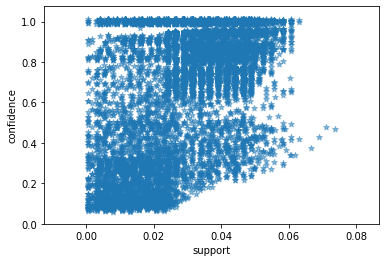

In [12]:
support=rules[['support']].values
confidence=rules[['confidence']].values
#confidence=rules.as_matrix(columns=['confidence'])
#coords = rules[["support", "confidence"]].values

import random
import matplotlib.pyplot as plt
 
for i in range (len(support)):
   support[i] = support[i] + 0.0025 * (random.randint(1,10) - 5) 
   confidence[i] = confidence[i] + 0.0025 * (random.randint(1,10) - 5)
 
plt.scatter(support, confidence,   alpha=0.5, marker="*")
plt.xlabel('support')
plt.ylabel('confidence') 
plt.show()

In [4]:
# pd.set_option('display.max_columns', None)  
# pd.set_option('display.expand_frame_repr', False)
# pd.set_option('max_colwidth', -1)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets


,support,itemsets,length
0,0.011944,(B19_20),1
1,0.018458,(B34_9),1
2,0.013029,(B96_89),1
3,0.074919,(B99_9),1
4,0.021716,(C09_9),1
...,...,...,...
1429,0.011944,"(T78_40, R50_9, J03_90, R53_81, R63_8)",5
1430,0.016287,"(T78_40, K56_609, J34_89, J30_9, R09_81)",5
1431,0.010858,"(M41_9, R91_8, K63_5, J34_89, J32_9)",5
1432,0.013029,"(C18_9, N73_9, B99_9, I25_2, T14_90, B96_89)",6


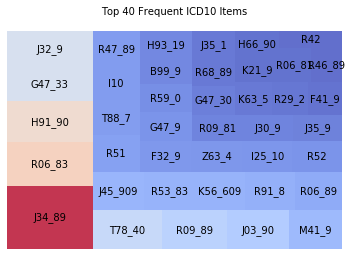

In [5]:
import matplotlib 
import squarify

transactions = pd.DataFrame(te_ary, columns=te.columns_)
pf = transactions.describe()
f = pf.iloc[0]-pf.iloc[3]
a = f.tolist()
b = list(f.index)
item = pd.DataFrame([[a[r],b[r]]for r in range(len(a))], columns=['Count','Item'])
item = item.sort_values(['Count'], ascending=False).head(40)
transactions


fig, ax = plt.subplots()
cmap = matplotlib.cm.coolwarm

mini = min(item["Count"])
maxi = max(item["Count"])

norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in item["Count"]]

squarify.plot(sizes=item["Count"], label=item["Item"], alpha=0.8, color=colors)
plt.axis('off')
plt.title("Top 40 Frequent ICD10 Items", fontsize=10)
ttl = ax.title
ttl.set_position([.5, 1.05])

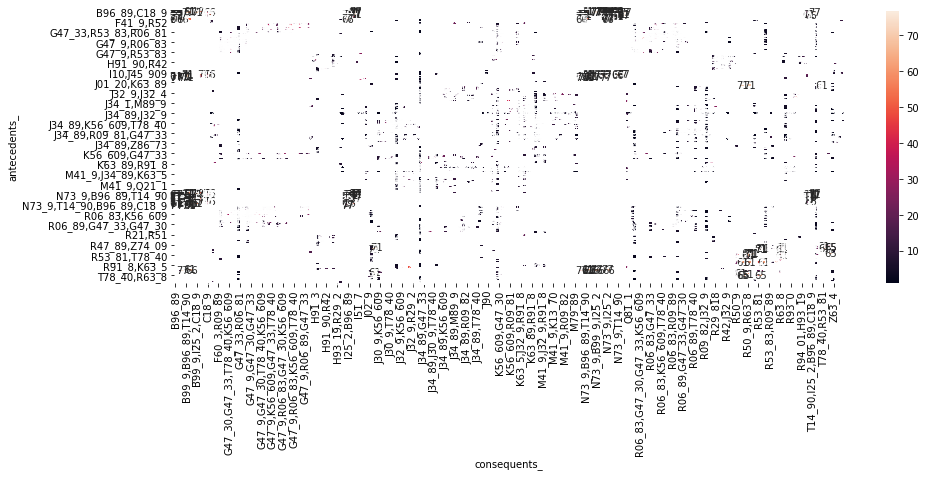

In [352]:
#item

rules['lhs items'] = rules['antecedents'].apply(lambda x:len(x) )
rules[rules['lhs items']>1].sort_values('lift', ascending=False).head()
import matplotlib.pyplot as plt
import seaborn as sns
# Replace frozen sets with strings
rules['antecedents_'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents_'] = rules['consequents'].apply(lambda a: ','.join(list(a)))
# Transform the DataFrame of rules into a matrix using the lift metric
pivot = rules[rules['lhs items']>1].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')
# Generate a heatmap with annotations on and the colorbar off
plt.figure(figsize = (15,5))
sns.heatmap(pivot, annot = True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

In [7]:
import icd10
print(icd10.find('R59.0').description)
print(icd10.find('J43.9').description)


Localized enlarged lymph nodes
Emphysema, unspecified


In [8]:
import icd10
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

def icd_decode(x):
    icd_code=x.replace('_','.').replace(' ','')
    code = icd10.find(icd_code)
    return code.description


for i in frequent_itemsets.iterrows():
    icdlist0=[]
    icdlist1=[]
    for k in list(i[1][1]):
        icdlist0.append(icd_decode(k))
    print(icdlist0)

C:\Users\Weeck\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


['Unspecified viral hepatitis C without hepatic coma']
['Viral infection, unspecified']
['Other specified bacterial agents as the cause of diseases classified elsewhere']
['Unspecified infectious disease']
['Malignant neoplasm of tonsil, unspecified']
['Malignant neoplasm of colon, unspecified']
['Malignant neoplasm of unspecified site of left female breast']
['Benign neoplasm of cranial nerves']
['Iron deficiency anemia, unspecified']
['Anemia, unspecified']
['Eosinophilia']
['Hypothyroidism, unspecified']
['Disorder of thyroid, unspecified']
['Type 2 diabetes mellitus without complications']
['Hypopituitarism']
['Disorder of pituitary gland, unspecified']
['Disorder of adrenal gland, unspecified']
['Vitamin D deficiency, unspecified']
['Obesity, unspecified']
['Pure hypercholesterolemia, unspecified']
['Hyperlipidemia, unspecified']
['Unspecified dementia without behavioral disturbance']
['Major depressive disorder, single episode, unspecified']
['Anxiety disorder, unspecified']
['Bo

['Gastro-esophageal reflux disease without esophagitis', 'Erythematous condition, unspecified']
['Gastro-esophageal reflux disease without esophagitis', 'Disorder of the skin and subcutaneous tissue, unspecified']
['Gastro-esophageal reflux disease without esophagitis', 'Bilateral primary osteoarthritis of knee']
['Gastro-esophageal reflux disease without esophagitis', 'Unspecified osteoarthritis, unspecified site']
['Gastro-esophageal reflux disease without esophagitis', 'Snoring']
['Other abnormalities of breathing', 'Gastro-esophageal reflux disease without esophagitis']
['Nasal congestion', 'Gastro-esophageal reflux disease without esophagitis']
['Other specified symptoms and signs involving the circulatory and respiratory systems', 'Gastro-esophageal reflux disease without esophagitis']
['Gastro-esophageal reflux disease without esophagitis', 'Dysphonia']
['Gastro-esophageal reflux disease without esophagitis', 'Headache']
['Gastro-esophageal reflux disease without esophagitis', '

['Scoliosis, unspecified', 'Unspecified intestinal obstruction, unspecified as to partial versus complete obstruction', 'Chronic sinusitis, unspecified', 'Atrial septal defect']
['Unspecified intestinal obstruction, unspecified as to partial versus complete obstruction', 'Chronic sinusitis, unspecified', 'Abnormal findings on diagnostic imaging of other parts of musculoskeletal system', 'Atrial septal defect']
['Scoliosis, unspecified', 'Chronic sinusitis, unspecified', 'Other nonspecific abnormal finding of lung field', 'Polyp of colon']
['Unspecified intestinal obstruction, unspecified as to partial versus complete obstruction', 'Other specified disorders of nose and nasal sinuses', 'Other specified diseases of intestine', 'Unspecified lesions of oral mucosa']
['Scoliosis, unspecified', 'Unspecified intestinal obstruction, unspecified as to partial versus complete obstruction', 'Other specified disorders of nose and nasal sinuses', 'Unspecified lesions of oral mucosa']
['Scoliosis, u

In [9]:
confid_itemsets
for i in confid_itemsets.iterrows():
    antecedents=[]
    consequents=[]
    for j in list(i[1][0]):
       antecedents.append(icd_decode(j))
    for k in list(i[1][1]):
        consequents.append(icd_decode(k))
        
    print(antecedents,'*****',consequents)


['Obstructive sleep apnea (adult) (pediatric)'] ***** ['Other specified disorders of nose and nasal sinuses']
['Other specified disorders of nose and nasal sinuses'] ***** ['Obstructive sleep apnea (adult) (pediatric)']
['Unspecified asthma, uncomplicated'] ***** ['Obstructive sleep apnea (adult) (pediatric)']
['Obstructive sleep apnea (adult) (pediatric)'] ***** ['Unspecified asthma, uncomplicated']
['Other specified disorders of nose and nasal sinuses'] ***** ['Dizziness and giddiness']
['Dizziness and giddiness'] ***** ['Other specified disorders of nose and nasal sinuses']
['Allergy, unspecified'] ***** ['Headache']
['Headache'] ***** ['Allergy, unspecified']
['Polyp of colon'] ***** ['Unspecified hearing loss, unspecified ear']
['Unspecified hearing loss, unspecified ear'] ***** ['Polyp of colon']
['Pain, unspecified'] ***** ['Obstructive sleep apnea (adult) (pediatric)']
['Obstructive sleep apnea (adult) (pediatric)'] ***** ['Pain, unspecified']
['Obstructive sleep apnea (adult) 

['Essential (primary) hypertension'] ***** ['Atherosclerotic heart disease of native coronary artery without angina pectoris']
['Other symptoms and signs involving appearance and behavior'] ***** ['Snoring']
['Snoring'] ***** ['Other symptoms and signs involving appearance and behavior']
['Other specified symptoms and signs involving the circulatory and respiratory systems'] ***** ['Abnormal reflex']
['Abnormal reflex'] ***** ['Other specified symptoms and signs involving the circulatory and respiratory systems']
['Other abnormalities of breathing', 'Allergy, unspecified'] ***** ['Other specified disorders of nose and nasal sinuses']
['Other specified disorders of nose and nasal sinuses'] ***** ['Other abnormalities of breathing', 'Allergy, unspecified']
['Obstructive sleep apnea (adult) (pediatric)'] ***** ['Allergy, unspecified']
['Allergy, unspecified'] ***** ['Obstructive sleep apnea (adult) (pediatric)']
['Allergy, unspecified'] ***** ['Fever, unspecified']
['Fever, unspecified'] 

['Other specified disorders of nose and nasal sinuses'] ***** ['Disappearance and death of family member', 'Chronic sinusitis, unspecified']
['Unspecified adverse effect of drug or medicament', 'Allergic rhinitis, unspecified'] ***** ['Other specified disorders of nose and nasal sinuses']
['Other specified disorders of nose and nasal sinuses'] ***** ['Unspecified adverse effect of drug or medicament', 'Allergic rhinitis, unspecified']
['Disturbances of salivary secretion'] ***** ['Other specified disorders of nose and nasal sinuses']
['Other specified disorders of brain'] ***** ['Other specified disorders of nose and nasal sinuses']
['Other specified disorders of nose and nasal sinuses'] ***** ['Other specified disorders of brain']
['Other specified disorders of nose and nasal sinuses'] ***** ['Allergy, unspecified', 'Chronic sinusitis, unspecified']
['Allergy, unspecified', 'Chronic sinusitis, unspecified'] ***** ['Other specified disorders of nose and nasal sinuses']
['Headache', 'Ot

['Other nonspecific abnormal finding of lung field', 'Acute ethmoidal sinusitis, unspecified'] ***** ['Other specified disorders of nose and nasal sinuses']
['Nasal congestion', 'Obstructive sleep apnea (adult) (pediatric)'] ***** ['Other specified disorders of nose and nasal sinuses']
['Other specified disorders of nose and nasal sinuses'] ***** ['Other nonspecific abnormal finding of lung field', 'Acute ethmoidal sinusitis, unspecified']
['Chronic sinusitis, unspecified', 'Unspecified adverse effect of drug or medicament'] ***** ['Other specified disorders of nose and nasal sinuses']
['Other specified disorders of nose and nasal sinuses'] ***** ['Occlusion and stenosis of right carotid artery']
['Other specified disorders of nose and nasal sinuses'] ***** ['Nasal congestion', 'Obstructive sleep apnea (adult) (pediatric)']
['Other specified disorders of nose and nasal sinuses'] ***** ['Chronic sinusitis, unspecified', 'Unspecified adverse effect of drug or medicament']
['Other nonspec

['Other specified disorders of nose and nasal sinuses'] ***** ['Atherosclerotic heart disease of native coronary artery without angina pectoris', 'Polyp of colon']
['Atherosclerotic heart disease of native coronary artery without angina pectoris', 'Polyp of colon'] ***** ['Other specified disorders of nose and nasal sinuses']
['Scoliosis, unspecified', 'Allergic rhinitis, unspecified'] ***** ['Other specified disorders of nose and nasal sinuses']
['Atherosclerotic heart disease of native coronary artery without angina pectoris', 'Acute ethmoidal sinusitis, unspecified'] ***** ['Other specified disorders of nose and nasal sinuses']
['Disorder of pituitary gland, unspecified'] ***** ['Other specified disorders of nose and nasal sinuses']
['Nasal congestion', 'Unspecified adverse effect of drug or medicament'] ***** ['Other specified disorders of nose and nasal sinuses']
['Other specified symptoms and signs involving the circulatory and respiratory systems'] ***** ['Other specified disord

['Other specified disorders of nose and nasal sinuses'] ***** ['Scoliosis, unspecified', 'Chronic obstructive pulmonary disease, unspecified']
['Scoliosis, unspecified', 'Periapical abscess without sinus'] ***** ['Other specified disorders of nose and nasal sinuses']
['Other specified disorders of nose and nasal sinuses'] ***** ['Scoliosis, unspecified', 'Periapical abscess without sinus']
['Nasal congestion', 'Gastro-esophageal reflux disease without esophagitis'] ***** ['Other specified disorders of nose and nasal sinuses']
['Other specified disorders of nose and nasal sinuses'] ***** ['Nasal congestion', 'Gastro-esophageal reflux disease without esophagitis']
['Unspecified intestinal obstruction, unspecified as to partial versus complete obstruction', 'Other specified diseases of intestine'] ***** ['Other specified disorders of nose and nasal sinuses']
['Other specified disorders of nose and nasal sinuses'] ***** ['Other specified symptoms and signs involving the circulatory and res

['Unspecified intestinal obstruction, unspecified as to partial versus complete obstruction', 'Allergy, unspecified', 'Sleep disorder, unspecified'] ***** ['Snoring']
['Snoring'] ***** ['Unspecified intestinal obstruction, unspecified as to partial versus complete obstruction', 'Allergy, unspecified', 'Sleep disorder, unspecified']
['Unspecified adverse effect of drug or medicament'] ***** ['Allergy, unspecified']
['Allergy, unspecified'] ***** ['Unspecified adverse effect of drug or medicament']
['Headache'] ***** ['Rash and other nonspecific skin eruption']
['Rash and other nonspecific skin eruption'] ***** ['Headache']
['Chronic sinusitis, unspecified'] ***** ['Atherosclerotic heart disease of native coronary artery without angina pectoris', 'Other specified disorders of nose and nasal sinuses']
['Atherosclerotic heart disease of native coronary artery without angina pectoris', 'Other specified disorders of nose and nasal sinuses'] ***** ['Chronic sinusitis, unspecified']
['Unspecif

['Snoring'] ***** ['Unspecified intestinal obstruction, unspecified as to partial versus complete obstruction', 'Sleep disorder, unspecified', 'Sleep apnea, unspecified']
['Unspecified intestinal obstruction, unspecified as to partial versus complete obstruction', 'Sleep disorder, unspecified', 'Sleep apnea, unspecified'] ***** ['Snoring']
['Other fatigue'] ***** ['Sleep disorder, unspecified', 'Sleep apnea, unspecified']
['Sleep disorder, unspecified', 'Sleep apnea, unspecified'] ***** ['Other fatigue']
['Acute tonsillitis, unspecified'] ***** ['Acute pharyngitis, unspecified']
['Acute pharyngitis, unspecified'] ***** ['Acute tonsillitis, unspecified']
['Other speech disturbances', 'Unspecified hearing loss, unspecified ear'] ***** ['Tinnitus, unspecified ear']
['Tinnitus, unspecified ear'] ***** ['Other speech disturbances', 'Unspecified hearing loss, unspecified ear']
['Allergy, unspecified', 'Sleep apnea, unspecified'] ***** ['Obstructive sleep apnea (adult) (pediatric)']
['Obstruc

['Fever, unspecified', 'Other symptoms and signs concerning food and fluid intake'] ***** ['Allergy, unspecified']
['Acute tonsillitis, unspecified', 'Other symptoms and signs concerning food and fluid intake', 'Fever, unspecified'] ***** ['Allergy, unspecified']
['Unspecified adverse effect of drug or medicament', 'Allergic rhinitis, unspecified'] ***** ['Allergy, unspecified']
['Acute tonsillitis, unspecified', 'Other symptoms and signs concerning food and fluid intake'] ***** ['Allergy, unspecified']
['Allergy, unspecified'] ***** ['Acute tonsillitis, unspecified', 'Other symptoms and signs concerning food and fluid intake']
['Allergy, unspecified'] ***** ['Fever, unspecified', 'Other symptoms and signs concerning food and fluid intake']
['Allergy, unspecified'] ***** ['Unspecified adverse effect of drug or medicament', 'Allergic rhinitis, unspecified']
['Allergy, unspecified'] ***** ['Acute tonsillitis, unspecified', 'Other symptoms and signs concerning food and fluid intake', 'Fev

['Tinnitus, unspecified ear', 'Unspecified hearing loss, unspecified ear'] ***** ['Abnormal reflex']
['Abnormal reflex'] ***** ['Tinnitus, unspecified ear', 'Unspecified hearing loss, unspecified ear']
['Snoring', 'Obstructive sleep apnea (adult) (pediatric)'] ***** ['Sleep apnea, unspecified']
['Sleep apnea, unspecified'] ***** ['Snoring', 'Obstructive sleep apnea (adult) (pediatric)']
['Otalgia, unspecified ear', 'Unspecified hearing loss, unspecified ear'] ***** ['Tinnitus, unspecified ear']
['Tinnitus, unspecified ear'] ***** ['Otalgia, unspecified ear', 'Unspecified hearing loss, unspecified ear']
['Dizziness and giddiness', 'Unspecified hearing loss, unspecified ear'] ***** ['Abnormal electroencephalogram [EEG]']
['Abnormal electroencephalogram [EEG]'] ***** ['Dizziness and giddiness', 'Unspecified hearing loss, unspecified ear']
['Other abnormalities of breathing'] ***** ['Unspecified intestinal obstruction, unspecified as to partial versus complete obstruction', 'Obstructive sl

['Other fatigue', 'Snoring', 'Sleep disorder, unspecified', 'Sleep apnea, unspecified'] ***** ['Obstructive sleep apnea (adult) (pediatric)']
['Other specified symptoms and signs involving the circulatory and respiratory systems', 'Headache'] ***** ['Disappearance and death of family member']
['Disappearance and death of family member'] ***** ['Other specified symptoms and signs involving the circulatory and respiratory systems', 'Headache']
['Other abnormalities of breathing', 'Obstructive sleep apnea (adult) (pediatric)'] ***** ['Snoring', 'Sleep disorder, unspecified']
['Snoring', 'Sleep disorder, unspecified'] ***** ['Other abnormalities of breathing', 'Obstructive sleep apnea (adult) (pediatric)']
['Tinnitus, unspecified ear'] ***** ['Unspecified hearing loss, unspecified ear', 'Other general symptoms and signs']
['Unspecified hearing loss, unspecified ear', 'Other general symptoms and signs'] ***** ['Tinnitus, unspecified ear']
['Scoliosis, unspecified', 'Chronic sinusitis, unspe

['Other specified diseases of intestine'] ***** ['Scoliosis, unspecified', 'Other specified symptoms and signs involving the circulatory and respiratory systems']
['Scoliosis, unspecified'] ***** ['Unspecified intestinal obstruction, unspecified as to partial versus complete obstruction', 'Atrial septal defect']
['Unspecified intestinal obstruction, unspecified as to partial versus complete obstruction', 'Atrial septal defect'] ***** ['Scoliosis, unspecified']
['Unspecified intestinal obstruction, unspecified as to partial versus complete obstruction', 'Chronic sinusitis, unspecified', 'Atrial septal defect'] ***** ['Scoliosis, unspecified']
['Scoliosis, unspecified'] ***** ['Unspecified intestinal obstruction, unspecified as to partial versus complete obstruction', 'Chronic sinusitis, unspecified', 'Atrial septal defect']
['Other specified disorders of nose and nasal sinuses', 'Chronic sinusitis, unspecified', 'Unspecified lesions of oral mucosa'] ***** ['Unspecified intestinal obstru

['Atrioventricular block, second degree'] ***** ['Dizziness and giddiness']
['Dizziness and giddiness'] ***** ['Deaf nonspeaking, not elsewhere classified']
['Dizziness and giddiness'] ***** ['Atrioventricular block, second degree']
['Anxiety disorder, unspecified', 'Chronic sinusitis, unspecified'] ***** ['Major depressive disorder, single episode, unspecified']
['Major depressive disorder, single episode, unspecified'] ***** ['Anxiety disorder, unspecified', 'Chronic sinusitis, unspecified']
['Sleep apnea, unspecified'] ***** ['Allergy, unspecified', 'Sleep disorder, unspecified']
['Allergy, unspecified', 'Sleep disorder, unspecified'] ***** ['Sleep apnea, unspecified']
['Other abnormalities of breathing', 'Unspecified intestinal obstruction, unspecified as to partial versus complete obstruction'] ***** ['Nasal congestion', 'Other specified disorders of nose and nasal sinuses']
['Other abnormalities of breathing', 'Sleep disorder, unspecified'] ***** ['Obstructive sleep apnea (adult)

['Benign neoplasm of cranial nerves'] ***** ['Dizziness and giddiness']
['Other specified diseases of intestine'] ***** ['Other specified disorders of nose and nasal sinuses', 'Disorder of bone, unspecified', 'Other nonspecific abnormal finding of lung field']
['Other specified disorders of nose and nasal sinuses', 'Disorder of bone, unspecified', 'Other nonspecific abnormal finding of lung field'] ***** ['Other specified diseases of intestine']
['Unspecified intestinal obstruction, unspecified as to partial versus complete obstruction', 'Sleep disorder, unspecified', 'Sleep apnea, unspecified'] ***** ['Snoring', 'Obstructive sleep apnea (adult) (pediatric)']
['Snoring', 'Obstructive sleep apnea (adult) (pediatric)'] ***** ['Unspecified intestinal obstruction, unspecified as to partial versus complete obstruction', 'Sleep disorder, unspecified', 'Sleep apnea, unspecified']
['Rash and other nonspecific skin eruption'] ***** ['Pruritus, unspecified']
['Pruritus, unspecified'] ***** ['Ras

['Unspecified intestinal obstruction, unspecified as to partial versus complete obstruction', 'Nasal congestion'] ***** ['Allergy, unspecified', 'Other specified disorders of nose and nasal sinuses']
['Other specified disorders of nose and nasal sinuses', 'Borderline personality disorder'] ***** ['Other specified soft tissue disorders']
['Other specified soft tissue disorders'] ***** ['Other specified disorders of nose and nasal sinuses', 'Borderline personality disorder']
['Nasal congestion', 'Allergic rhinitis, unspecified'] ***** ['Unspecified intestinal obstruction, unspecified as to partial versus complete obstruction', 'Other specified disorders of nose and nasal sinuses']
['Unspecified intestinal obstruction, unspecified as to partial versus complete obstruction', 'Other specified disorders of nose and nasal sinuses'] ***** ['Nasal congestion', 'Allergic rhinitis, unspecified']
['Other fatigue', 'Sleep disorder, unspecified'] ***** ['Snoring', 'Sleep apnea, unspecified']
['Snori

['Injury, unspecified'] ***** ['Female pelvic inflammatory disease, unspecified', 'Malignant neoplasm of colon, unspecified', 'Unspecified infectious disease']
['Snoring', 'Sleep apnea, unspecified'] ***** ['Unspecified intestinal obstruction, unspecified as to partial versus complete obstruction', 'Obstructive sleep apnea (adult) (pediatric)', 'Sleep disorder, unspecified']
['Unspecified intestinal obstruction, unspecified as to partial versus complete obstruction', 'Obstructive sleep apnea (adult) (pediatric)', 'Sleep disorder, unspecified'] ***** ['Snoring', 'Sleep apnea, unspecified']
['Allergy, unspecified', 'Sleep disorder, unspecified'] ***** ['Unspecified intestinal obstruction, unspecified as to partial versus complete obstruction', 'Snoring']
['Gastro-esophageal reflux disease without esophagitis', 'Unspecified hearing loss, unspecified ear'] ***** ['Unspecified abdominal hernia without obstruction or gangrene']
['Unspecified abdominal hernia without obstruction or gangrene']

['Allergy, unspecified', 'Sleep disorder, unspecified', 'Sleep apnea, unspecified'] ***** ['Unspecified intestinal obstruction, unspecified as to partial versus complete obstruction', 'Snoring', 'Obstructive sleep apnea (adult) (pediatric)']
['Injury, unspecified', 'Other specified bacterial agents as the cause of diseases classified elsewhere'] ***** ['Malignant neoplasm of colon, unspecified']
['Old myocardial infarction', 'Female pelvic inflammatory disease, unspecified', 'Other specified bacterial agents as the cause of diseases classified elsewhere'] ***** ['Malignant neoplasm of colon, unspecified']
['Other specified bacterial agents as the cause of diseases classified elsewhere'] ***** ['Malignant neoplasm of colon, unspecified']
['Malignant neoplasm of colon, unspecified'] ***** ['Other specified bacterial agents as the cause of diseases classified elsewhere']
['Malignant neoplasm of colon, unspecified'] ***** ['Female pelvic inflammatory disease, unspecified', 'Old myocardial 

['Old myocardial infarction', 'Female pelvic inflammatory disease, unspecified'] ***** ['Malignant neoplasm of colon, unspecified', 'Unspecified infectious disease']
['Other malaise', 'Acute tonsillitis, unspecified'] ***** ['Allergy, unspecified', 'Fever, unspecified']
['Injury, unspecified', 'Other specified bacterial agents as the cause of diseases classified elsewhere'] ***** ['Malignant neoplasm of colon, unspecified', 'Unspecified infectious disease']
['Injury, unspecified', 'Old myocardial infarction', 'Female pelvic inflammatory disease, unspecified'] ***** ['Malignant neoplasm of colon, unspecified', 'Unspecified infectious disease']
['Old myocardial infarction', 'Malignant neoplasm of colon, unspecified', 'Unspecified infectious disease'] ***** ['Other specified bacterial agents as the cause of diseases classified elsewhere']
['Old myocardial infarction', 'Injury, unspecified'] ***** ['Malignant neoplasm of colon, unspecified', 'Unspecified infectious disease']
['Malignant ne